In [1]:
import torch
from fastai.vision.all import *
import timm
import rasterio as rio
import pandas as pd
from pathlib import Path
from functools import partial
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp

In [2]:
from augs import (
    BatchRot90,
    # RandomRectangle,
    DynamicZScoreNormalize,
    # SceneEdge,
    # BatchTear,
    BatchResample,
    RandomClipLargeImages,
    # RandomSharpenBlur,
    # ClipHighAndLow,
    BatchFlip,
)


In [3]:
from helpers import plot_batch, show_histo, print_system_info

print_system_info()


System Information
-----------------------------------
PyTorch Version : 2.7.1+cu126
CUDA Available  : Yes
CUDA Version    : 12.6
Python Version  : 3.12.11
Fastai Version  : 2.8.6
Default Device  : cuda:0
Device Name     : NVIDIA GeForce RTX 4090
-----------------------------------


In [4]:
print_system_info()

System Information
-----------------------------------
PyTorch Version : 2.7.1+cu126
CUDA Available  : Yes
CUDA Version    : 12.6
Python Version  : 3.12.11
Fastai Version  : 2.8.6
Default Device  : cuda:0
Device Name     : NVIDIA GeForce RTX 4090
-----------------------------------


In [5]:
model_provider = "smp"
# model_provider = "fastai"


In [6]:
# model_type = "regnety_004.pycls_in1k"
# model_type = "regnety_002.pycls_in1k"

# model_type = "edgenext_small.usi_in1k"
# model_type = "edgenext_x_small.usi_in1k"
# model_type = "edgenext_xx_small.usi_in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_pico.fcmae_ft_in1k"
model_type = "convnextv2_femto.fcmae_ft_in1k"
# model_type = "convnextv2_atto.fcmae_ft_in1k"


In [7]:
# model_type = "convnextv2_nano.fcmae_ft_in1k"  # 16 Pretty good
# model_type = "convnextv2_tiny.fcmae_ft_in22k_in1k_384"
# model_type = "convnextv2_base.fcmae_ft_in22k_in1k_384"  # 2 best

In [8]:
flair_training_data_dir = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches"
)
s1s2_training_data_dir = Path("/media/nick/4TB Working 6/Datasets/S1S2-Water/train")


In [9]:
sources = [flair_training_data_dir, s1s2_training_data_dir]
sources

[Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches'),
 Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')]

In [10]:
flair_water_only_csv_path = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR_patches_with_water.csv"
)

In [11]:
model_base_name = "2.0.1"

In [12]:
max_clip_image_clip_size = 500
min_clip_image_size = 256

In [13]:
only_water_flair = True

labels_folder_name = "labels"

batch_size = 32
GA_batch_size = 128

epoch_count = 15

learning_rate = 0.0001
# sample_frac = 0.5
sample_frac = 1
class_loss_weights = [1, 2]

# initial image size
original_image_size = 512
# bf16 if faster uses less memory then fp32 and is more stable than fp16
bf16 = True
class_count = 2

In [14]:
name_addition = "_S1S2"
name_addition += "_L2A"

name_addition += "_flair"
if only_water_flair:
    name_addition += "_only_water"


model_full_name = f"{model_base_name}{name_addition}_{model_type.split('.')[0]}"
model_full_name

'2.0.1_S1S2_L2A_flair_only_water_convnextv2_femto'

In [15]:
s1s2_limited_band_read_list = [3, 2, 1, 4]  # Red, Green, Blue, NIR,
flair_limited_band_read_list = [1, 2, 3, 4]  # Red, Green, Blue, NIR

In [16]:
if only_water_flair:
    flair_water_df = pd.read_csv(flair_water_only_csv_path)
    water_flair_imgs = flair_water_df["image_path"].values
    water_flair_imgs = [Path(img) for img in water_flair_imgs]
    print(len(water_flair_imgs))
    water_flair_imgs = set(water_flair_imgs)

16884


In [17]:
def get_image_files_custom(sources):
    all_train_images = []
    all_val_images = []

    for source in sources:
        images_dir = source / "images"
        assert images_dir.exists(), f"Images dir {images_dir} does not exist"

        if source == s1s2_training_data_dir:
            train_images = list(images_dir.glob("*train*.tif"))
            val_images = list(images_dir.glob("*val*.tif"))

        elif source == flair_training_data_dir:
            val_images = []
            if only_water_flair:
                train_images = list(water_flair_imgs)
            else:
                train_images = list(images_dir.glob("*train*.tif"))

        else:
            raise ValueError(f"Unknown source {source}")

        print(f"Found {len(train_images)} training images from {source}")
        print(f"Found {len(val_images)} validation images from {source}")

        all_train_images += train_images
        all_val_images += val_images
    if sample_frac < 1:
        print(f"But only using {sample_frac} of them")
        # take random sample of the data
        all_train_images = random.sample(
            all_train_images, int(len(all_train_images) * sample_frac)
        )

    print(f"Total training images: {len(all_train_images)}")
    print(f"Total validation images: {len(all_val_images)}")
    return all_train_images + all_val_images


In [18]:
_ = get_image_files_custom(sources)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 21632 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 21632


In [19]:
def label_func(file_path):
    file_name = file_path.name
    normalised_name = file_name.replace("_L2A", "")
    label_path = file_path.parent.parent / "labels" / normalised_name

    return label_path


def is_valid_file(x):
    if "val" in x.name:
        return True
    return False

In [20]:
train_and_val_images = get_image_files_custom(sources)
for image in tqdm(train_and_val_images):
    label_path = label_func(image)
    assert label_path.exists(), f"{label_path} does not exist"
len(train_and_val_images)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 21632 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 21632


  0%|          | 0/83132 [00:00<?, ?it/s]

83132

In [21]:
train_and_val_images[0].parents[1]

Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches')

In [22]:
s1s2_training_data_dir


Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')

In [23]:
def open_img(
    img_path: Path,
    img_size: int,
    bf16: bool,
) -> TensorImage:
    with rio.open(img_path) as src:
        if img_path.parents[1] == flair_training_data_dir:
            limited_band_read_list = flair_limited_band_read_list
        elif img_path.parents[1] == s1s2_training_data_dir:
            limited_band_read_list = s1s2_limited_band_read_list
        else:
            raise ValueError("Unknown training data dir")
        raw_bands = src.read(
            limited_band_read_list,
            out_shape=(img_size, img_size),
            resampling=rio.enums.Resampling.average,  # type: ignore
        ).astype(np.float32)

    image_tensor = torch.from_numpy(raw_bands)

    if bf16:
        image_tensor = image_tensor.bfloat16()

    return TensorImage(image_tensor)

In [24]:
open_img(train_and_val_images[0], original_image_size, bf16).shape

torch.Size([4, 512, 512])

In [25]:
# label_func_partial = partial(label_func, labels_dir)

open_img_no_cache_partial = partial(open_img, img_size=original_image_size, bf16=True)

In [26]:
blocks = (
    TransformBlock([open_img_no_cache_partial]),
    MaskBlock(codes=[0, 1]),
)

In [27]:
dblock = DataBlock(
    blocks=blocks,  # type: ignore
    get_items=get_image_files_custom,  # type: ignore
    get_y=label_func,  # type: ignore
    splitter=FuncSplitter(lambda x: is_valid_file(x)),  # type: ignore
    batch_tfms=[  # type: ignore
        IntToFloatTensor(1, 1),
        BatchFlip(),
        BatchRot90(),
        DynamicZScoreNormalize(),
        BatchResample(min_scale=0.2, max_scale=1.111),
        RandomClipLargeImages(  # Clips large images to a random size
            max_size=max_clip_image_clip_size, min_size=min_clip_image_size
        ),
    ],
)

In [28]:
dl = dblock.dataloaders(
    size=original_image_size,
    source=sources,
    bs=batch_size,
    num_workers=16,
    pin_memory=True,
)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 21632 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 21632


In [29]:
batch = dl.one_batch()
batch[0].shape

torch.Size([32, 4, 110, 110])

In [30]:
num_input_channels = batch[0].shape[1]
num_input_channels

4

In [31]:
band_labels = ["B04", "B03", "B02", "B08", "Slope"]
# band_labels = ["B03", "B08"]


band_labels

['B04', 'B03', 'B02', 'B08', 'Slope']

Image tensor shape: torch.Size([32, 4, 110, 110])
Label shape: torch.Size([32, 110, 110])


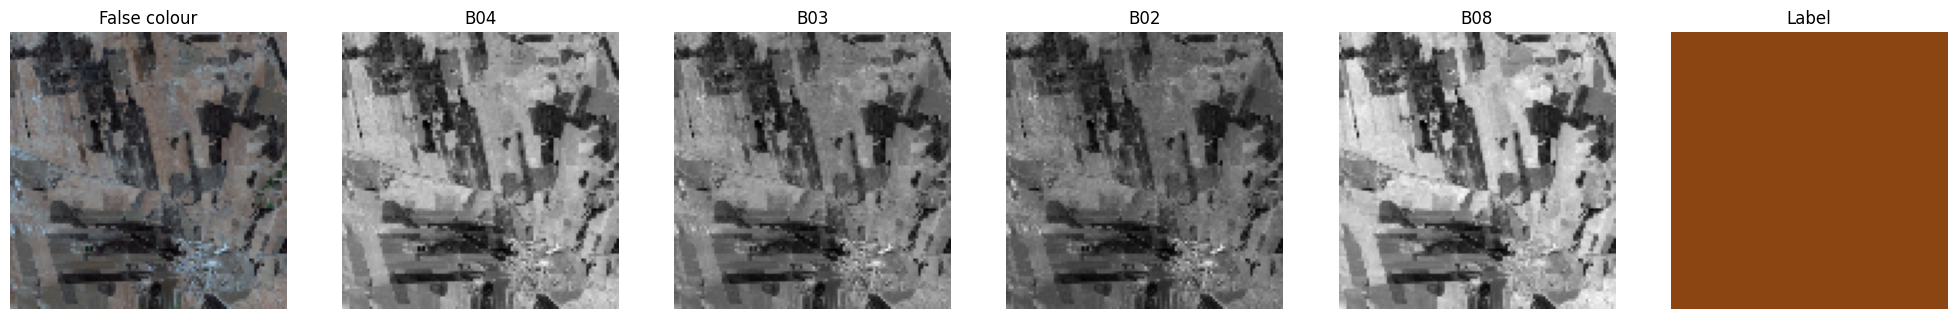

In [32]:
plot_batch(batch, labels=["False colour"] + band_labels)

In [33]:
batch[0][0][0].mean()

TensorImage(0.0146, device='cuda:0')

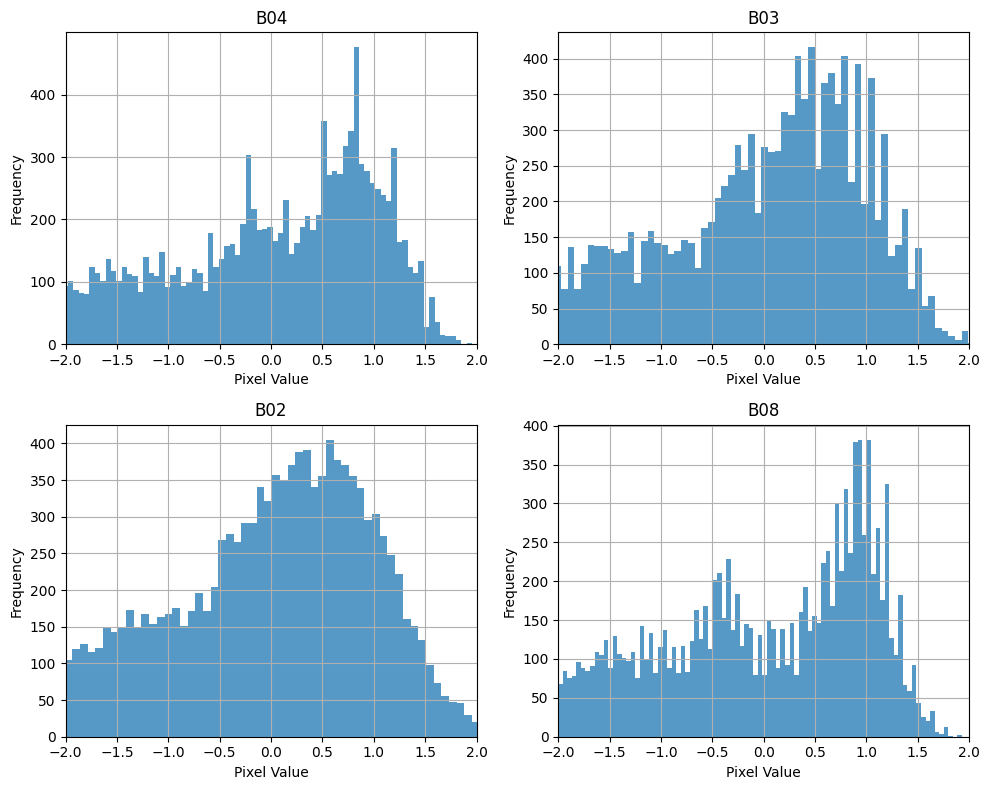

In [34]:
show_histo(batch, labels=band_labels)

In [35]:
batch[0].shape[1]

4

In [36]:
print(
    f"batch_size: {batch_size}, image_size: {original_image_size}, learning_rate: {learning_rate}"
)
fai_model_name = f"PM_model_{model_full_name}_fai"
pytorch_model_name = f"PM_model_{model_full_name}_PT.pth"
pytorch_model_path = Path.cwd() / "models" / pytorch_model_name
pytorch_model_weights_path = Path.cwd() / "models" / f"{pytorch_model_name}_weights.pth"
print(f"Fastai model {fai_model_name}")
print(f"Pytorch model {pytorch_model_path}")

batch_size: 32, image_size: 512, learning_rate: 0.0001
Fastai model PM_model_2.0.1_S1S2_L2A_flair_only_water_convnextv2_femto_fai
Pytorch model /home/nick/Documents/Work code/OmniWaterMask/training/models/PM_model_2.0.1_S1S2_L2A_flair_only_water_convnextv2_femto_PT.pth


In [37]:
if pytorch_model_path.exists():
    raise ValueError("Model already exists")

In [38]:
torch.tensor(class_loss_weights).float().cuda()

tensor([1., 2.], device='cuda:0')

In [39]:
# import cv2


# def distance_transform(
#     input_label: torch.Tensor | np.ndarray,
#     clip_distance: float = 3.0,
#     classes: list[int] = [0, 1],
# ) -> torch.Tensor:
#     # if numpy array convert to tensor
#     if isinstance(input_label, np.ndarray):
#         label = torch.from_numpy(input_label)
#     else:
#         label = input_label

#     label_np = label.numpy(force=True)

#     # if single image add channel dimension
#     if len(label_np.shape) == 2:
#         single_image = True
#         label_np = label_np[np.newaxis, :, :]
#     else:
#         single_image = False

#     output = np.zeros_like(label_np, dtype=np.float32)

#     for index, label_np in enumerate(label_np):
#         for class_int in classes:
#             class_mask = (label_np[index] == class_int).astype(np.uint8)
#             class_dist = cv2.distanceTransform(
#                 class_mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE
#             )
#             class_dist = (np.clip(class_dist, 1, clip_distance)) * class_mask
#             output[index] += class_dist

#     output = np.absolute(output - clip_distance - 1)

#     output = torch.from_numpy(output)

#     # if single image remove channel dimension
#     if single_image:
#         output = output.squeeze(0)

#     return output.to(label.device)

In [40]:
from distance_transform_optimized import distance_transform_torch as distance_transform


In [41]:
from torch.nn import CrossEntropyLoss

cel = CrossEntropyLoss(
    reduction="none", weight=torch.tensor(class_loss_weights).float().cuda()
)


def combo_loss(pred, target):
    pixel_weight = distance_transform(target, clip_distance=3)
    pixel_cel = cel(pred, target)
    return (pixel_cel * pixel_weight).mean()


loss_func = combo_loss

In [42]:
save_metric = "valid_loss"

In [43]:
callbacks = [
    SaveModelCallback(monitor=save_metric, fname=fai_model_name, with_opt=True),
    ShowGraphCallback(),
    GradientAccumulation(GA_batch_size),
]

In [44]:
if model_provider == "fastai":
    print(f"Using fastai model: {model_type}")
    timm_model = partial(
        timm.create_model,
        model_type,
        pretrained=True,
        in_chans=num_input_channels,
    )
    model = create_unet_model(
        img_size=(original_image_size, original_image_size),
        arch=timm_model,
        n_out=class_count,
        pretrained=True,
        act_cls=torch.nn.Mish,
    )
elif model_provider == "smp":
    print(f"Using segmentation_models_pytorch model: {model_type}")
    model = smp.Unet(
        encoder_name=f"tu-{model_type.split('.')[0]}",
        encoder_weights="imagenet",
        in_channels=num_input_channels,
        classes=class_count,
    )

else:
    raise ValueError(f"Unknown model provider: {model_provider}")


Using segmentation_models_pytorch model: convnextv2_femto.fcmae_ft_in1k


In [45]:
dummy_input = torch.randn(
    1, num_input_channels, original_image_size, original_image_size
)
model_output = model(dummy_input)
assert model_output.shape == (
    1,
    class_count,
    original_image_size,
    original_image_size,
), "Model output shape mismatch"


In [46]:
# import JaccardCoeffMulti from fastai
from fastai.metrics import JaccardCoeffMulti, JaccardCoeff

# metrics = [JaccardCoeffMulti(axis=1)]
metrics = [JaccardCoeffMulti(axis=1), JaccardCoeff(axis=1)]

In [47]:
learner = Learner(
    dls=dl,
    model=model,
    loss_func=loss_func,  # CrossEntropyLossFlat(axis=1),  # loss_func,
    metrics=metrics,
    cbs=callbacks,
)


In [48]:
if bf16:
    print("Using BF16")
    learner = learner.to_bf16()

print(f"Using learning rate: {learning_rate}, with model {model_type}")

Using BF16
Using learning rate: 0.0001, with model convnextv2_femto.fcmae_ft_in1k


epoch,train_loss,valid_loss,jaccard_coeff_multi,jaccard_coeff,time
0,0.338061,0.314760,0.889663,0.805933,05:59
1,0.141625,0.179677,0.909901,0.841183,05:50
2,0.098100,0.190246,0.916764,0.853197,05:49
3,0.100750,0.213617,0.908018,0.838525,05:41
4,0.092733,0.325712,0.873853,0.778407,05:25
5,0.089517,0.125600,0.898623,0.822470,05:25
6,0.082083,0.223417,0.915953,0.852472,05:25
7,0.071162,0.203130,0.914417,0.849144,05:25
8,0.082551,0.229842,0.910751,0.843184,05:25
9,0.071359,0.147086,0.919186,0.857645,05:39


Better model found at epoch 0 with valid_loss value: 0.3147601783275604.


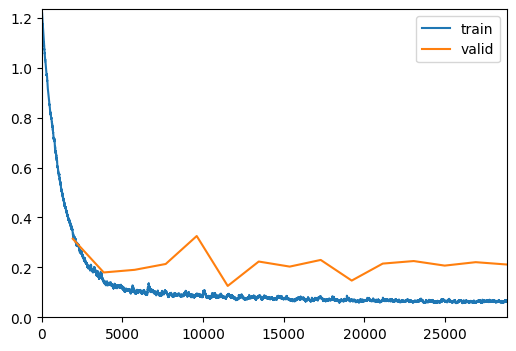

Better model found at epoch 1 with valid_loss value: 0.17967678606510162.
Better model found at epoch 5 with valid_loss value: 0.12559978663921356.


In [49]:
learner.fit_one_cycle(
    n_epoch=epoch_count,
    lr_max=learning_rate,
)


In [50]:
# PM_model_1.5.30_s1s2_water_flair_convnextv2_base_fai got 0.03851525858044624. then 0.03583391010761261
# PM_model_1.5.34_s1s2_water_flair_convnextv2_base_PT.pth got 0.03587641939520836 then 0.03264540061354637

In [51]:
#  reload the model to get the best one
learner.load(fai_model_name)
# extract model from learner and move to cpu
model = learner.model.to("cpu")
model = model.float()
# save the pytorch model
print(f"Saving torch model {pytorch_model_path}")
torch.save(model, pytorch_model_path)

# save the model weights
print(f"Saving torch model weights {pytorch_model_weights_path}")
torch.save(model.state_dict(), pytorch_model_weights_path)

torch.cuda.empty_cache()

Saving torch model /home/nick/Documents/Work code/OmniWaterMask/training/models/PM_model_2.0.1_S1S2_L2A_flair_only_water_convnextv2_femto_PT.pth
Saving torch model weights /home/nick/Documents/Work code/OmniWaterMask/training/models/PM_model_2.0.1_S1S2_L2A_flair_only_water_convnextv2_femto_PT.pth_weights.pth
